In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.calibration import calibration_curve


from data.dataset import get_dataloaders

import pickle
import langid

from IPython.display import display

# Load data

In [2]:
data_path = "../data/"
dataset = get_dataloaders(model_name=None, data_path=data_path, use_cache=False, batch_size=64, debug=1, comment_column='kommentar_original')
results_e5 = pd.DataFrame(dataset['test']['text'], columns=['text'])
results_nb = pd.DataFrame()

In [3]:
with open(data_path + 'e5-preds.pkl', 'rb') as f:
    e5_res_vals = pickle.load(f)
with open(data_path + 'nb-preds.pkl', 'rb') as f:
    naivebayes_vals = pickle.load(f)

In [4]:
results_e5['labels'] = e5_res_vals['labels']
results_e5['e5_predictions'] = e5_res_vals['predictions']
results_e5['e5_neg_prob'] = e5_res_vals['probabilities'][:,0]
results_e5['e5_pos_prob'] = e5_res_vals['probabilities'][:,1]
results_nb['labels'] = naivebayes_vals['labels']
results_nb['naivebayes_predictions'] = naivebayes_vals['predictions']
results_nb['naivebayes_neg_prob'] = naivebayes_vals['probabilities'][:,0]
results_nb['naivebayes_pos_prob'] = naivebayes_vals['probabilities'][:,1]

In [5]:
langid.set_languages(['fr', 'de'])
results_e5['language'] = results_e5["text"].apply(lambda x :langid.classify(x)[0])
results_de = results_e5[results_e5['language'] == 'de']
results_fr = results_e5[results_e5['language'] == 'fr']

# Results

### General metrics

In [6]:
def calculate_metrics(model_name, predictions, labels):
    scores = ['f1', 'precision', 'recall']
    params = ['micro', 'macro', 'weighted', 'binary']
    columns = ['model','accuracy'] + [score + '_' + param for score in scores for param in params]
    df = pd.DataFrame(0, index = [0], columns=columns + ['f1_binary_neg'])
    df.iloc[0, 0] = model_name
    df.iloc[0, 1] = balanced_accuracy_score(predictions, labels)
    i = 2
    for param in params:
        df.loc[0, f'{scores[0]}_{param}'] = f1_score(predictions, labels, average=param)
        df.loc[0, f'{scores[1]}_{param}'] = precision_score(predictions, labels, average=param)
        df.loc[0, f'{scores[2]}_{param}'] = recall_score(predictions, labels, average=param)
        i=i+3

    df.loc[0, f'{scores[0]}_binary_neg'] = f1_score(1 - predictions, 1 - labels, average='binary')

    return df

def get_general_metrics(df_list, name_list, model_list, confidence=0.5):
    for model in model_list:
        res = []
        for df, name in zip(df_list, name_list):
            df = df[df[[model + '_neg_prob', model + '_pos_prob']].max(axis=1) >= confidence]
            res.append(calculate_metrics(model + '_' + name, df[model + '_predictions'], df['labels']))
    return pd.concat(res)

In [7]:
metrics = get_general_metrics([results_e5, results_de, results_fr], ['all', 'de', 'fr'], ['e5'])
metrics

,model,accuracy,f1_micro,f1_macro,f1_weighted,f1_binary,precision_micro,precision_macro,precision_weighted,precision_binary,recall_micro,recall_macro,recall_weighted,recall_binary,f1_binary_neg
0,e5_all,0.749290,0.839985,0.777048,0.827131,0.658591,0.839985,0.846628,0.842238,0.857010,0.839985,0.749290,0.839985,0.534778,0.895504
0,e5_de,0.741892,0.870942,0.776792,0.859499,0.631826,0.870942,0.847557,0.865874,0.815452,0.870942,0.741892,0.870942,0.515699,0.921758
0,e5_fr,0.751793,0.756988,0.745264,0.746724,0.690615,0.756988,0.800212,0.797342,0.907642,0.756988,0.751793,0.756988,0.557347,0.799913


In [8]:
metrics = get_general_metrics([results_nb], ['all'], ['naivebayes'])
metrics

,model,accuracy,f1_micro,f1_macro,f1_weighted,f1_binary,precision_micro,precision_macro,precision_weighted,precision_binary,recall_micro,recall_macro,recall_weighted,recall_binary,f1_binary_neg
0,naivebayes_all,0.633204,0.722719,0.638904,0.695002,0.464935,0.722719,0.702639,0.712739,0.671319,0.722719,0.633204,0.722719,0.355609,0.812873


### Calibration plots

In [9]:
def plot_calibration(model_list, df_list):
    fig, ax = plt.subplots(1, len(model_list), figsize=(12,5))
    for i, (model, df) in enumerate(zip(model_list, df_list)):
        prob_true, prob_pred = calibration_curve(df['labels'], df[model + '_pos_prob'], n_bins=10)
        fig.suptitle('Calibration plot per model')
        ax[i].set_title(model)
        ax[i].plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
        ax[i].plot(prob_pred, prob_true, marker='o', linewidth=1, label=model)
        ax[i].set_xlabel('Mean predicted probability (positive class)')
        ax[i].set_ylabel('Fraction of positives (positive class)')

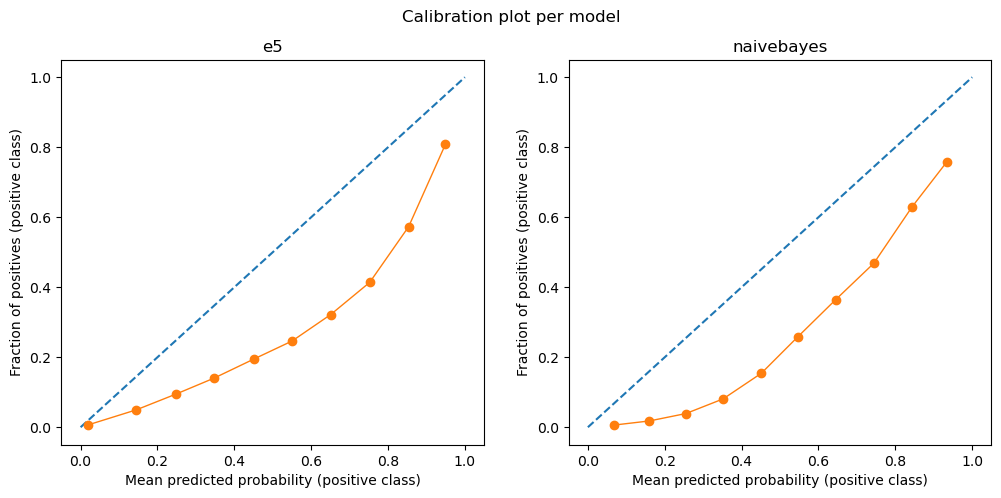

In [10]:
plot_calibration(['e5', 'naivebayes'], [results_e5, results_nb])

### Confusion matrix

In [11]:
def plot_confusionmatrix(model_list, df_list):
    fig, ax = plt.subplots(1, len(model_list), figsize=(15,5))
    for i, (model, df) in enumerate(zip(model_list, df_list)):
        cf_matrix = confusion_matrix(df['labels'], df[model + '_predictions'])
        df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = ["No Hatespeech","Hatespeech"], columns = ["No Hatespeech","Hatespeech"])
        fig.suptitle('Calibration plot per model')
        sns.heatmap(df_cm, ax=ax[i])
        ax[i].set_title(model)
        ax[i].set_xlabel('Predicted')
        ax[i].set_ylabel('True')

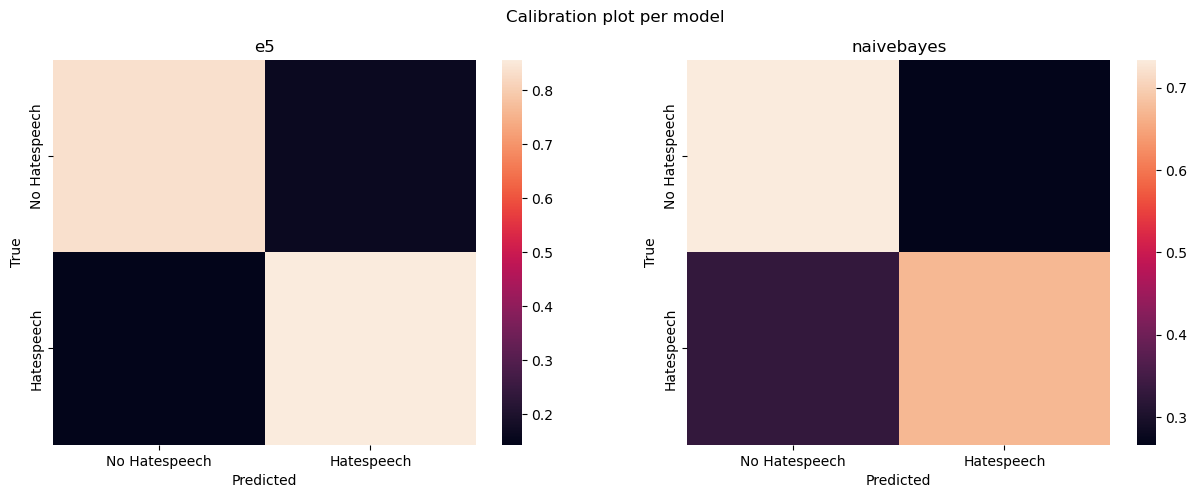

In [12]:
plot_confusionmatrix(['e5', 'naivebayes'], [results_e5, results_nb])

### Confidently right and wrong

In [13]:
model = 'e5'
df_confident = results_e5[results_e5[[model + '_neg_prob', model + '_pos_prob']].max(axis=1) >= 0.95].reset_index(drop=True)

In [14]:
confidently_wrong = df_confident[df_confident[model +'_predictions'] != df_confident['labels']].reset_index(drop=True)[["text", "labels", 'e5_predictions']]
confidently_right= df_confident[df_confident[model +'_predictions'] == df_confident['labels']].reset_index(drop=True)[["text", "labels", 'e5_predictions']]

In [ ]:
pd.set_option('display.max_colwidth', 1000)
display(confidently_right[confidently_right['labels'] == 0].head())
display(confidently_right[confidently_right['labels'] == 1].head())
pd.set_option('display.max_colwidth', 100)

In [ ]:
pd.set_option('display.max_colwidth', 1000)
display(confidently_wrong[confidently_wrong['labels'] == 0].head())
display(confidently_wrong[confidently_wrong['labels'] == 1].head())
pd.set_option('display.max_colwidth', 100)

# Preprocess NB

In [ ]:
with open(data_path + 'nb-preds_de.pkl', 'rb') as f:
    naivebayes_vals_de = pickle.load(f)
with open(data_path + 'nb-preds_fr.pkl', 'rb') as f:
    naivebayes_vals_fr = pickle.load(f)

In [ ]:
naivebayes_vals_fr['probabilities']

In [ ]:
np.concatenate((naivebayes_vals_de['probabilities'], naivebayes_vals_fr['probabilities']))

In [ ]:
naivebayes_vals = {'probabilities':np.concatenate((naivebayes_vals_de['probabilities'], naivebayes_vals_fr['probabilities'])), 'labels':np.concatenate((naivebayes_vals_de['labels'], naivebayes_vals_fr['labels'])), 'predictions':np.concatenate((naivebayes_vals_de['predictions'], naivebayes_vals_fr['predictions']))}

In [ ]:
import pickle
with open(data_path + 'nb-preds.pkl', 'wb') as f:
    pickle.dump(naivebayes_vals, f)